In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
sns.set(style='whitegrid',context='notebook')
plt.rcParams['figure.figsize'] = (5, 5)

height has been deprecated.



In [2]:
df = pd.read_csv('./datasets/sequentialFirmIds.csv',index_col=0)

In [17]:
df.shape

(574, 84)

In [4]:
rm_col = ['firmid','firmsectionid','clientid','revenueid','processid','processtechnologyuseid',
          'financialsid','firmanalyticsresultid','firmannualreportid_x','RevenueBreakdownId',
          'OperatingExpensesId','OtherIncomeAndExpensesId','OperatingExpenseAdjustmentsId',
          'firmannualreportid_y','TotalNetRevenue','firmannualreportid','TotalOutstandingAssets',
          'Aum','ProjectedAnnualGrowthRate','RecurringRevenuePercent','TotalOutstandingLiabilities',
          'OtherPercent','ispassive','isadvisor']
df.drop(rm_col,axis=1,inplace=True)


In [5]:
numerical_cols = df.columns[:65]
N = len(numerical_cols)
numerical_cols

Index([u'year', u'yearsinbusiness', u'employeecount', u'ClientsCount', u'AverageClientAge', u'AverageClientRelationshipLength', u'AverageClientAdditions', u'AverageClientDepartures', u'ReferralRate', u'InstitutionalAumPercent', u'TopFiveClientsAumPercent', u'BeneficiaryLevel', u'ClientMeetingFrequency', u'DiscretionaryInvestmentAumPercent', u'AverageBasisPointsForAdvisory', u'NonCompetes', u'SuccessionPlan', u'ManagementRetentionProgram', u'ContinuityPlan', u'CompensationBonusPlan', u'StockOwnershipPlan', u'TechnologyDisasterRecoveryPlan', u'RecentLegalIssues', u'CurrentLegalIssues', u'crm', u'accounting', u'portfoliomanagement', u'portfolioaccounting', u'financialplanning', u'firmwebsite', u'clientportal', u'socialmedia', u'email', u'digitalcompliancemonitoring', u'digitalfinancialrecords', u'robotechnology', u'riskassessmentsoftware', u'age_x', u'yearjoinedfirm_x', u'age_y', u'ownershippercent', u'yearjoinedfirm_y', u'EquityPercent', u'FixedIncomePercent', u'MutualFundsPercent',
    

# NetRevenue Regression

In [6]:
X = df[numerical_cols].values.reshape(-1,N)
y = df['NetRevenue'].values.reshape(-1,1)

#standardize
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

In [7]:
cv = ShuffleSplit(n_splits=20, test_size=0.25, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X_std,y_std, test_size=.2, random_state=42)

R^2 Train: 0.99925, test: 0.99296
MSE Train: 0.00078, test: 0.00599


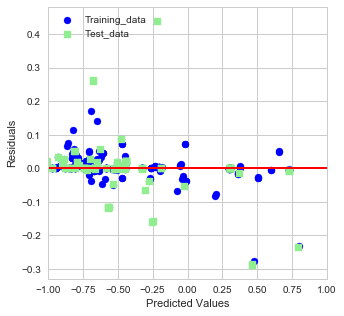

In [8]:
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=42,
                               n_jobs=-1,
                               oob_score=True)
forest.fit(X_train,y_train.reshape(-1))
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('R^2 Train: %.5f, test: %.5f' % (r2_score(y_train,y_train_pred),r2_score(y_test, y_test_pred)))

print('MSE Train: %.5f, test: %.5f' % (mean_squared_error(y_train,y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
plt.scatter(y_train_pred,(y_train_pred.reshape(-1,1)-y_train),c='blue',label='Training_data',marker='o')
plt.scatter(y_test_pred,(y_test_pred.reshape(-1,1)-y_test),c='lightgreen',marker='s',label='Test_data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
plt.xlim([-1,1])
plt.show()

In [9]:
fts = forest.feature_importances_
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = numerical_cols
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

,type,feature_importance
60,insurance,0.259107
1,yearsinbusiness,0.182773
3,ClientsCount,0.076521
10,TopFiveClientsAumPercent,0.071270
56,technology,0.068499
6,AverageClientAdditions,0.055630
50,FinancialPlanningAndConsultingPercent,0.034246
57,professionalservices,0.025695
31,socialmedia,0.024913
53,othercompensationandbenefits,0.024375


# OperatingExpenses Regression

R^2 Train: 0.99868, test: 0.98841
MSE Train: 0.00137, test: 0.00972


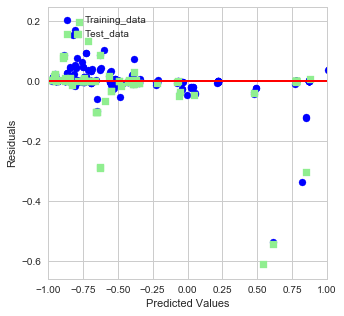

In [13]:
X = df[numerical_cols].values.reshape(-1,N)
y = df['OperatingExpenses'].values.reshape(-1,1)

#standardize
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

cv = ShuffleSplit(n_splits=20, test_size=0.25, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X_std,y_std, test_size=.2, random_state=42)

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=42,
                               n_jobs=-1,
                               oob_score=True)
forest.fit(X_train,y_train.reshape(-1))
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('R^2 Train: %.5f, test: %.5f' % (r2_score(y_train,y_train_pred),r2_score(y_test, y_test_pred)))

print('MSE Train: %.5f, test: %.5f' % (mean_squared_error(y_train,y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
plt.scatter(y_train_pred,(y_train_pred.reshape(-1,1)-y_train),c='blue',label='Training_data',marker='o')
plt.scatter(y_test_pred,(y_test_pred.reshape(-1,1)-y_test),c='lightgreen',marker='s',label='Test_data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
plt.xlim([-1,1])
plt.show()

In [14]:
fts = forest.feature_importances_
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = numerical_cols
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

,type,feature_importance
56,technology,0.342555
3,ClientsCount,0.129116
44,MutualFundsPercent,0.094560
1,yearsinbusiness,0.082340
50,FinancialPlanningAndConsultingPercent,0.060893
6,AverageClientAdditions,0.057129
52,totaldirectexpense,0.023592
60,insurance,0.015257
33,digitalcompliancemonitoring,0.014409
58,marketingandbusinessdevelopment,0.013014


# Ebitda Regression

R^2 Train: 0.99895, test: 0.99130
MSE Train: 0.00101, test: 0.00978


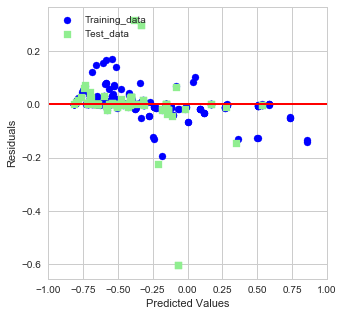

In [15]:
X = df[numerical_cols].values.reshape(-1,N)
y = df['Ebitda'].values.reshape(-1,1)

#standardize
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

cv = ShuffleSplit(n_splits=20, test_size=0.25, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X_std,y_std, test_size=.2, random_state=42)

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=42,
                               n_jobs=-1,
                               oob_score=True)
forest.fit(X_train,y_train.reshape(-1))
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('R^2 Train: %.5f, test: %.5f' % (r2_score(y_train,y_train_pred),r2_score(y_test, y_test_pred)))

print('MSE Train: %.5f, test: %.5f' % (mean_squared_error(y_train,y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
plt.scatter(y_train_pred,(y_train_pred.reshape(-1,1)-y_train),c='blue',label='Training_data',marker='o')
plt.scatter(y_test_pred,(y_test_pred.reshape(-1,1)-y_test),c='lightgreen',marker='s',label='Test_data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
plt.xlim([-1,1])
plt.show()

In [16]:
fts = forest.feature_importances_
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = numerical_cols
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

,type,feature_importance
50,FinancialPlanningAndConsultingPercent,0.153580
53,othercompensationandbenefits,0.135189
6,AverageClientAdditions,0.133319
61,other,0.108795
54,officeexpenses,0.100300
1,yearsinbusiness,0.049010
59,travelandentertainment,0.044843
57,professionalservices,0.035168
60,insurance,0.033610
10,TopFiveClientsAumPercent,0.031640


# Eboc Regression

R^2 Train: 0.99879, test: 0.98656
MSE Train: 0.00123, test: 0.01263


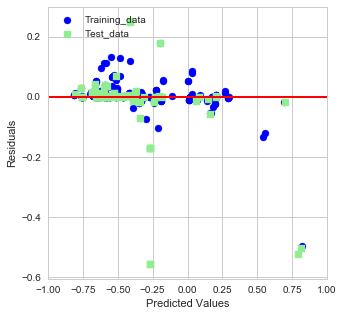

In [18]:
X = df[numerical_cols].values.reshape(-1,N)
y = df['Eboc'].values.reshape(-1,1)

#standardize
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

cv = ShuffleSplit(n_splits=20, test_size=0.25, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X_std,y_std, test_size=.2, random_state=42)

forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=42,
                               n_jobs=-1,
                               oob_score=True)
forest.fit(X_train,y_train.reshape(-1))
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('R^2 Train: %.5f, test: %.5f' % (r2_score(y_train,y_train_pred),r2_score(y_test, y_test_pred)))

print('MSE Train: %.5f, test: %.5f' % (mean_squared_error(y_train,y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
plt.scatter(y_train_pred,(y_train_pred.reshape(-1,1)-y_train),c='blue',label='Training_data',marker='o')
plt.scatter(y_test_pred,(y_test_pred.reshape(-1,1)-y_test),c='lightgreen',marker='s',label='Test_data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
plt.xlim([-1,1])
plt.show()

In [19]:
fts = forest.feature_importances_
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = numerical_cols
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

,type,feature_importance
1,yearsinbusiness,0.184816
60,insurance,0.167233
50,FinancialPlanningAndConsultingPercent,0.109637
10,TopFiveClientsAumPercent,0.107459
53,othercompensationandbenefits,0.065815
61,other,0.046577
59,travelandentertainment,0.038534
54,officeexpenses,0.026022
6,AverageClientAdditions,0.024070
56,technology,0.019841
